In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.metrics import (
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	roc_curve,
	auc,
	classification_report
)

In [2]:
def carregar_dados_csv(file):

	try:

		df_completo = pd.read_csv(file)

		return df_completo

	except FileNotFoundError:

		print(f"Erro: O arquivo '{file}' não foi encontrado.")
		print("Rode o ZeaMays para gerar o arquivo CSV.")
		return None

	except KeyError as e:

		print(f"Erro: Uma ou mais colunas não encontradas no arquivo: {e}")
		return None

	except Exception as e:

		print(f"Ocorreu um erro inesperado: {e}")
		return None

In [3]:
# metricas = "df_metricas_seq.csv"
metricas = "/kaggle/input/zea-mays-1-0/df_metricas_seq.csv"

df_metricas = carregar_dados_csv(metricas)

if df_metricas is not None:
	print("\nHead do DataFrame:")
	print(df_metricas.shape)
	print(df_metricas.head())


Head do DataFrame:
(67686, 5766)
   Chr SourceAnnotation                                    COS      Start  \
0    1           APTEdb  Class II subclass 2/Helitron/Helitron  185134318   
1    1           APTEdb  Class II subclass 2/Helitron/Helitron  108502298   
2    9           APTEdb  Class II subclass 2/Helitron/Helitron   77998293   
3    4           APTEdb  Class II subclass 2/Helitron/Helitron  206727217   
4    8           APTEdb  Class II subclass 2/Helitron/Helitron  165674147   

         End Score Strand Phase  \
0  185151509     .      -     .   
1  108504248     .      -     .   
2   78002783     .      +     .   
3  206731508     .      +     .   
4  165674275     .      -     .   

                                          Attributes  \
0  TE-Score=0.714;Software=HelitronScanner;Length...   
1  TE-Score=0.428;Software=HelitronScanner;Length...   
2  TE-Score=0.714;Software=HelitronScanner;Length...   
3  TE-Score=0.428;Software=HelitronScanner;Length...   
4  TE-Score=

In [4]:
remover_colunas = ["Chr", "SourceAnnotation", "Start", "End", "Score", "Strand", "Phase", "Attributes", "label"]

df_modificado = df_metricas.drop(columns=remover_colunas)

print("\nDataFrame após remover colunas:")
print(df_modificado.shape)
print(df_modificado.head())


DataFrame após remover colunas:
(67686, 5757)
                                     COS  ZMays/Agrup\anf_fourier_average  \
0  Class II subclass 2/Helitron/Helitron                      1109.133954   
1  Class II subclass 2/Helitron/Helitron                       146.131903   
2  Class II subclass 2/Helitron/Helitron                       306.033744   
3  Class II subclass 2/Helitron/Helitron                       306.207420   
4  Class II subclass 2/Helitron/Helitron                        11.691824   

   ZMays/Agrup\anf_fourier_median  ZMays/Agrup\anf_fourier_maximum  \
0                       10.007322                     1.881748e+07   
1                        6.389373                     2.643780e+05   
2                        6.873558                     1.326329e+06   
3                        8.069504                     1.260339e+06   
4                        0.949723                     1.346578e+03   

   ZMays/Agrup\anf_fourier_minimum  ZMays/Agrup\anf_fourier_peak  \
0

In [5]:
coluna_alvo = 'COS'

In [6]:
def verfica_unique (df, coluna):
	
	if coluna in df.columns:

		contagem_valores = df[coluna].value_counts()

		print(f"Contagem de cada valor único na coluna '{coluna}':")
		print(contagem_valores)

		valores_unicos = df[coluna].unique()
		print(f"\nValores únicos na coluna '{coluna}':")
		print(valores_unicos)

		numero_de_valores_unicos = df[coluna].nunique()
		print(f"\nA coluna '{coluna}' possui {numero_de_valores_unicos} valores únicos distintos.")

	else:
		print(f"A coluna '{coluna}' não foi encontrada no DataFrame.")
		print("Colunas disponíveis:", df.columns.tolist())

verfica_unique(df_modificado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
Class I/LTR/Gypsy                         20805
Class I/LTR/Copia                         11109
Class II subclass 2/Helitron/Helitron      5020
Class II subclass 2/MITE/MITE              4357
Class I/LTR/LARD                           3206
Class II subclass 1/TIR/PIF-Harbinger      3033
Class I/LTR/Unknown                        2914
Class II subclass 1/TIR/hAT                2363
Class II subclass 1/TIR/Harbinger          2007
Class II subclass 1/TIR/CMC-EnSpm          1562
Class II subclass 1/TIR/Unknown            1562
Class I/LINE/L1                            1485
Class II subclass 1/TIR/EnSpm-CACTA        1472
Class II subclass 1/TIR/MuDR               1387
Class II subclass 1/TIR/hAT-Ac             1175
Class II subclass 1/TIR/MuLE-MuDR           813
Class I/SINE/tRNA                           530
Class II subclass 1/TIR/TcMar-Stowaway      462
Class II subclass I/TIR/Unknown             401
Class II subclass 1/TIR/Tc1-Mariner   

In [7]:
def extrair_elemento_transponivel(texto):
  
	try:
		return texto.split('/')[1]
	except IndexError:
		return
	
df_modificado[coluna_alvo] = df_modificado[coluna_alvo].apply(extrair_elemento_transponivel)

verfica_unique(df_modificado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38484
TIR         17000
Helitron     5020
MITE         4357
LINE         2089
SINE          736
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [8]:
ocorrencia = 1

contagens = df_modificado[coluna_alvo].value_counts()

valores_para_manter = contagens[contagens > ocorrencia].index

df_filtrado = df_modificado[df_modificado[coluna_alvo].isin(valores_para_manter)]

verfica_unique(df_filtrado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38484
TIR         17000
Helitron     5020
MITE         4357
LINE         2089
SINE          736
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [1]:
df_filtrado.shape

NameError: name 'df_filtrado' is not defined

In [12]:
# 1. Encontra todas as colunas que começam com o prefixo "chaos_"
colunas_para_remover = [col for col in df_filtrado.columns if col.startswith('ZMays/Agrup\chaos_')]

# 2. Cria um novo DataFrame sem essas colunas
# O .drop() retorna um novo DataFrame, não modifica o original
df_filtrado = df_filtrado.drop(columns=colunas_para_remover)

# Opcional: verifique as colunas removidas e o novo formato
print("Colunas removidas:", colunas_para_remover)
print("\nNovo formato do DataFrame:", df_filtrado.shape)
print("Primeiras linhas do DataFrame limpo:")
print(df_filtrado.head())

Colunas removidas: ['ZMays/Agrup\\chaos_signal_classic_average', 'ZMays/Agrup\\chaos_signal_classic_median', 'ZMays/Agrup\\chaos_signal_classic_maximum', 'ZMays/Agrup\\chaos_signal_classic_minimum', 'ZMays/Agrup\\chaos_signal_classic_peak', 'ZMays/Agrup\\chaos_signal_classic_none_levated_peak', 'ZMays/Agrup\\chaos_signal_classic_sample_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_population_standard_deviation', 'ZMays/Agrup\\chaos_signal_classic_percentile15', 'ZMays/Agrup\\chaos_signal_classic_percentile25', 'ZMays/Agrup\\chaos_signal_classic_percentile50', 'ZMays/Agrup\\chaos_signal_classic_percentile75', 'ZMays/Agrup\\chaos_signal_classic_amplitude', 'ZMays/Agrup\\chaos_signal_classic_variance', 'ZMays/Agrup\\chaos_signal_classic_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_semi_interquartile_range', 'ZMays/Agrup\\chaos_signal_classic_coefficient_of_variation', 'ZMays/Agrup\\chaos_signal_classic_skewness', 'ZMays/Agrup\\chaos_signal_classic_kurtosis', 'ZMays/A

In [ ]:
nome_coluna_alvo = 'COS'

df_modelo = df_filtrado.copy()

# Amostragem de 10% do DataFrame filtrado para um pseudo-treinamento
# df_modelo = df_filtrado.sample(frac=0.01, random_state=42)

if nome_coluna_alvo not in df_modelo.columns:

	print(f"ERRO: Coluna alvo '{nome_coluna_alvo}' não encontrada no DataFrame!")

else:
  df_modelo.dropna(inplace=True)
  y_original = df_modelo[nome_coluna_alvo]
  X_original = df_modelo.drop(columns=[nome_coluna_alvo])

  print(f"\nVariável Alvo Selecionada: '{nome_coluna_alvo}' (Multiclasse)")
  print("-" * 50)

  # Codificar Features Categóricas em X (One-Hot Encoding)
  colunas_categoricas_X = X_original.select_dtypes(include=['object', 'category']).columns
  X_codificado = pd.get_dummies(X_original, columns=colunas_categoricas_X, drop_first=True)
  feature_names = X_codificado.columns.tolist()

  print("\nFeatures (X) após One-Hot Encoding (primeiras linhas):")
  print(X_codificado.head())
  print(f"Número de features após encoding: {X_codificado.shape[1]}")
  print("-" * 50)

  # Codificar Variável Alvo (y) para formato numérico 0..N-1
  le = LabelEncoder()
  y_codificada = le.fit_transform(y_original) # Converte strings/categorias para 0, 1, 2...

  print(f"\nCodificação da Variável Alvo '{nome_coluna_alvo}':")
  print("Classes originais:", le.classes_)
  print("Classes codificadas (únicas):", np.unique(y_codificada))
  print("Alvo (y) após codificação (primeiras ocorrências):", y_codificada[:5])
  print("-" * 50)

  print(df_modelo.shape)



Variável Alvo Selecionada: 'COS' (Multiclasse)
--------------------------------------------------


In [ ]:
def kfold_classification(model, X, y, n_splits=5, average='weighted'):
	kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

	# Converta y para array numpy se for Series/DataFrame
	y = np.array(y) if not isinstance(y, np.ndarray) else y

	# Métricas de classificação
	f1_scores, precision_scores, recall_scores, confusion_matrices = [], [], [], []

	for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
		# Para matrizes esparsas, usamos índices diretamente
		X_train, X_test = X[train_idx], X[test_idx]
		y_train, y_test = y[train_idx], y[test_idx]

		# Treino com barra de progresso
		with tqdm(total=100, desc=f"Fold {fold+1}/{n_splits}", leave=False) as pbar:
			model.fit(X_train, y_train)
			for _ in range(100):
				pbar.update(1)

		# Predição
		y_pred = model.predict(X_test)

		# Cálculo de métricas
		f1 = f1_score(y_test, y_pred, average=average)
		precision = precision_score(y_test, y_pred, average=average)
		recall = recall_score(y_test, y_pred, average=average)

		f1_scores.append(f1)
		precision_scores.append(precision)
		recall_scores.append(recall)

		# Armazena relatórios completos
		confusion_matrices.append(confusion_matrix(y_test, y_pred))

		fpr, tpr = [], []
		#y_pred_proba = model.predict_proba(X_test) # Probabilidades para a curva ROC
		for i, class_label in enumerate(model.classes_):
			fpr_i, tpr_i, _ = roc_curve(y_test == class_label, y_pred == class_label)
			fpr.append(fpr_i)
			tpr.append(tpr_i)

	# Retorno dos resultados
	return {
		'f1': {
			'mean': np.mean(f1_scores),
			'std': np.std(f1_scores),
			'all': f1_scores
		},
		'precision': {
			'mean': np.mean(precision_scores),
			'std': np.std(precision_scores),
			'all': precision_scores
		},
		'recall': {
			'mean': np.mean(recall_scores),
			'std': np.std(recall_scores),
			'all': recall_scores
		},
		'confusion_matrices': confusion_matrices,
		'fpr': fpr,
		'tpr': tpr,
	}

In [ ]:
k_values = [3,5,7,10]
modelNames = ['XGBoost', 'RF', 'GBT', 'SVM']

params_rf = {'n_estimators': 100, 'random_state': 42, 'min_samples_split': 2, 'min_samples_leaf':1}
params_rf.update(n_estimators=120, class_weight='balanced')
rf_model = RandomForestClassifier(**params_rf)

params_xgb = {
	'n_estimators': 100,
	'random_state': 42,
	'use_label_encoder': False,
	'eval_metric': 'logloss'
}
params_xgb['objective'] = 'multi:softprob'
params_xgb['eval_metric'] = 'mlogloss'
params_xgb.update(n_estimators=120, learning_rate=0.1, max_depth=4)
xgb_model = XGBClassifier(n_estimators=120, learning_rate=0.1, max_depth=4)

gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)

models = [xgb_model, rf_model, gbt_model, svm_model]
results = []

output_dir = '/kaggle/working/models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Iniciando avaliação de K-Fold e salvamento de modelos\n")
for i in range(len(models)):
	result = {
		'model_name': modelNames[i],
		'f1': {},
		'precision': {},
		'recall': {},
		'confusion_matrices': {},
		'fpr': {},
		'tpr': {}
	}

	X_input = X_codificado.values if hasattr(X_codificado, 'values') else X_codificado
	y_input = y_codificada.values if hasattr(y_codificada, 'values') else y_codificada

	if modelNames[i] == 'SVM':
		scaler = StandardScaler()
		X_input = scaler.fit_transform(X_input)

	for k in k_values:
		print(f"\n Model = {modelNames[i]} --- K = {k}")
		metrics = kfold_classification(models[i], X_input, y_input, n_splits=k)

		result['f1'][k] = {'mean': metrics['f1']['mean'], 'std': metrics['f1']['std'], 'all': metrics['f1']['all']}
		result['precision'][k] = {'mean': metrics['precision']['mean'], 'std': metrics['precision']['std'], 'all': metrics['precision']['all']}
		result['recall'][k] = {'mean': metrics['recall']['mean'], 'std': metrics['recall']['std'], 'all': metrics['recall']['all']}
		result['confusion_matrices'][k] = metrics['confusion_matrices']
		result['fpr'][k], result['tpr'][k] = metrics['fpr'], metrics['tpr']

	results.append(result)

	print(f"\n----------------------------------------------------")
	print(f"Treinando e salvando modelo final para: {modelNames[i]}...")

	final_model_to_save = models[i]
	final_model_to_save.fit(X_input, y_input)

	file_path = os.path.join(output_dir, f'modelo_{modelNames[i].lower()}_final.joblib')
	joblib.dump(final_model_to_save, file_path)
	print(f"Modelo final salvo em: {file_path}")

	if modelNames[i] == 'SVM':
		scaler_path = os.path.join(output_dir, 'scaler_svm.joblib')
		joblib.dump(scaler, scaler_path)
		print(f"Scaler do SVM salvo em: {scaler_path}")

	results_path = os.path.join(output_dir, 'evaluation_results.joblib')
	joblib.dump(results, results_path)
	print(f"Resultados de avaliação intermediários salvos em: {results_path}")
	print(f"----------------------------------------------------\n")

In [29]:
def plot_single_model_results(display_name, model_results, model_object, k_values, feature_names):
    """
    Plota os resultados da validação k-fold para um único modelo.

    Args:
        display_name (str): O nome 'bonito' do modelo para usar nos títulos.
        model_results (dict): Dicionário contendo os resultados (f1, precision, etc.) para o modelo.
        model_object (object): O objeto do modelo treinado (carregado do joblib).
        k_values (list): A lista de valores de K usados (ex: [3, 5, 7, 10]).
        feature_names (list): Lista com os nomes das colunas/features.
    """
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    metrics = ['f1', 'precision', 'recall']
    metric_names = ['F1-Score', 'Precision', 'Recall']

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f'Desempenho do Modelo: {display_name}\n', fontsize=16, fontweight='bold')
    gs = fig.add_gridspec(2, 3, height_ratios=[3, 1])
    ax_main = fig.add_subplot(gs[0, :])

    for j, metric in enumerate(metrics):
        x = k_values
        y = [model_results[metric][k]['mean'] for k in x]
        y_err = [model_results[metric][k]['std'] for k in x]
        ax_main.errorbar(x, y, yerr=y_err, fmt='-o', color=colors[j],
                       ecolor=colors[j]+'AA', capsize=5, linewidth=2.5,
                       markersize=8, label=metric_names[j])
        for k, val in zip(x, y):
            ax_main.text(k, val + 0.01, f'{val:.3f}', ha='center', va='bottom',
                       fontsize=9, color=colors[j])

    ax_main.set_title('Métricas por Número de Folds', pad=20, fontsize=14)
    ax_main.set_xlabel('Número de Folds (K)', labelpad=10, fontsize=12)
    ax_main.set_ylabel('Valor da Métrica', labelpad=10, fontsize=12)
    ax_main.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
    ax_main.grid(True, alpha=0.3)
    ax_main.set_ylim(0, 1.05)
    plt.show()

    print("\nMATRIZES DE CONFUSÃO")
    for k in k_values:
        fig_conf, axes = plt.subplots(1, 1, figsize=(8, 4))
        fig_conf.suptitle(f'{display_name} - Matriz de Confusão do Teste (K={k})', y=1.05)
        cm = model_results['confusion_matrices'][k][-1]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_object.classes_)
        disp.plot(ax=axes, cmap='Blues', values_format='d', colorbar=True)
        axes.set_title(f'Fold {k}')
        axes.set_xlabel('Valores preditos')
        axes.set_ylabel('Valores reais')
        plt.tight_layout()
        plt.show()

    print(f"\n Resumo Estatístico - {display_name}")
    print(f"{'K':<5} {'F1-Score':<10} {'Precision':<10} {'Recall':<10}")
    print("-" * 40)
    for k in k_values:
        print(f"{k:<5}", end=" ")
        for metric in metrics:
            val = model_results[metric][k]['mean']
            print(f"{val:.4f}".ljust(10), end=" ")
        print()
    print("\n" + "=" * 60 + "\n")

    if hasattr(model_object, 'feature_importances_'):
        importances = model_object.feature_importances_
        indices = np.argsort(importances)[::-1]
        num_features_to_plot = min(len(feature_names), 20)
        plt.figure(figsize=(12, max(6, num_features_to_plot * 0.3)))
        plt.title(f"Importância das Features - {display_name} (Top {num_features_to_plot})")
        sns.barplot(x=importances[indices][:num_features_to_plot],
                    y=[feature_names[i] for i in indices[:num_features_to_plot]])
        plt.xlabel("Importância Relativa")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    print(f"--- Avaliação de {display_name} Concluída ---")

Arquivo de resultados '/kaggle/input/modelskfoldzeamays/modelo_evaluation_kfold.joblib' carregado com sucesso.

--- INICIANDO GERAÇÃO DE GRÁFICOS ---

==================== ANÁLISE DO MODELO: RANDOM FOREST ====================
Objeto do modelo carregado de: /kaggle/input/modelskfoldzeamays/modelo_rf_kfold.joblib


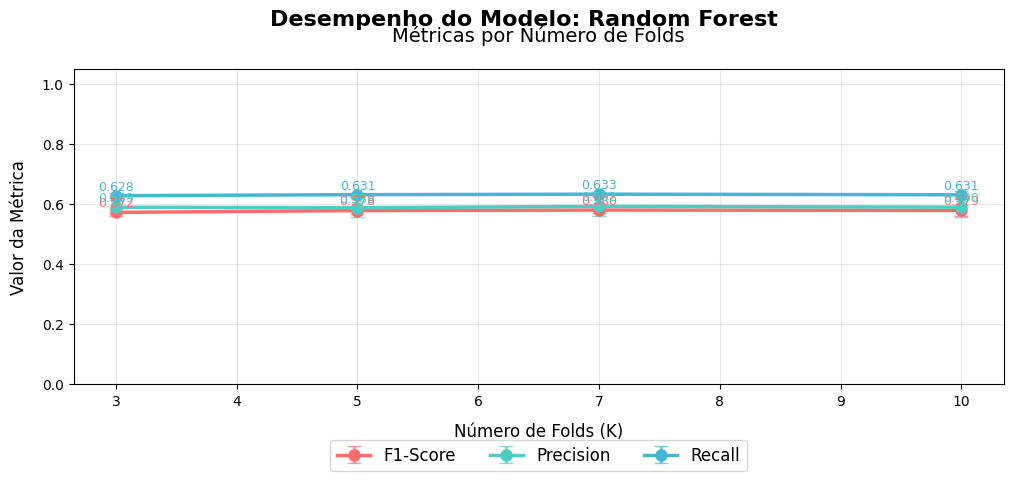


MATRIZES DE CONFUSÃO


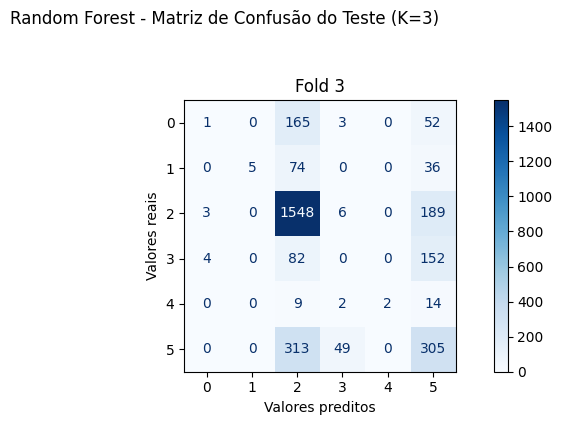

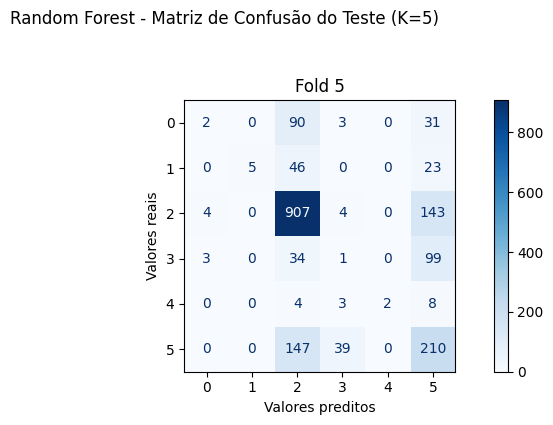

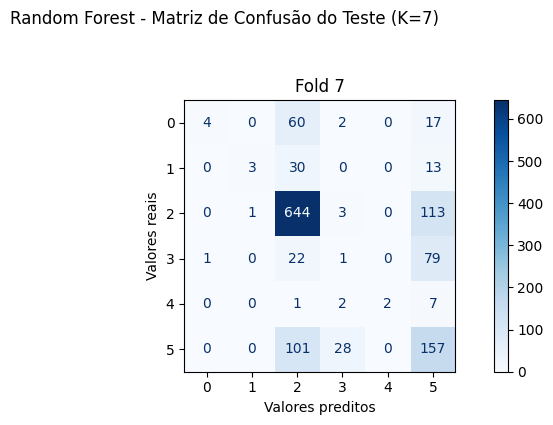

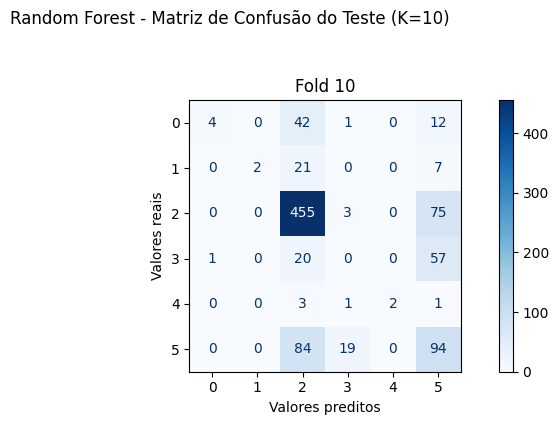


 Resumo Estatístico - Random Forest
K     F1-Score   Precision  Recall    
----------------------------------------
3     0.5723     0.5894     0.6280     
5     0.5783     0.5878     0.6314     
7     0.5800     0.5925     0.6330     
10    0.5790     0.5898     0.6311     




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


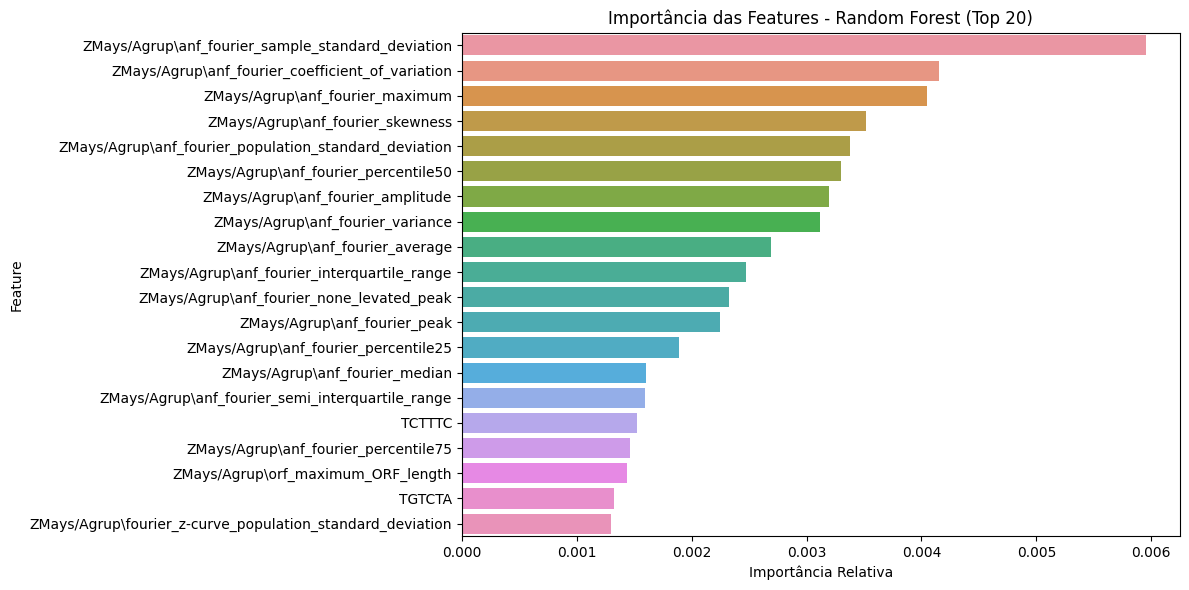

--- Avaliação de Random Forest Concluída ---

==================== ANÁLISE DO MODELO: XGBOOST ====================
Objeto do modelo carregado de: /kaggle/input/modelskfoldzeamays/modelo_xgboost_kfold.joblib


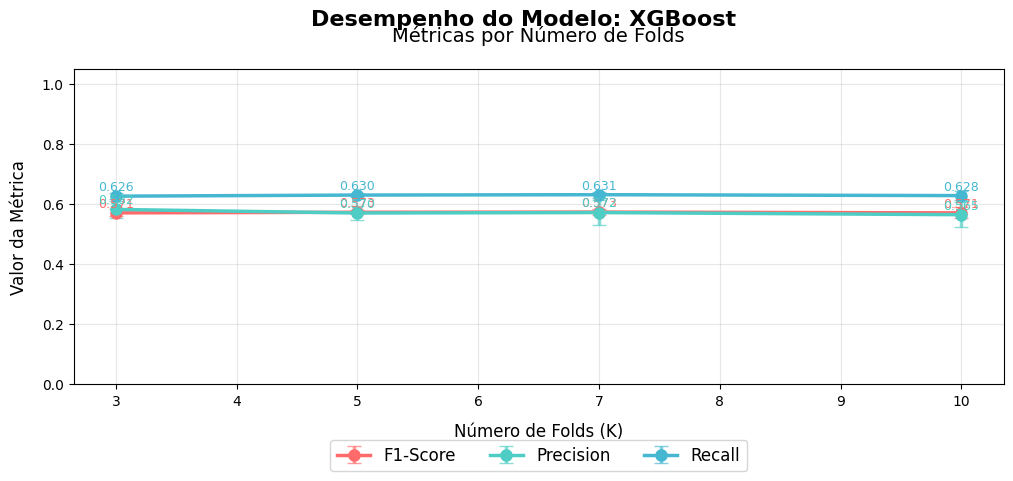


MATRIZES DE CONFUSÃO


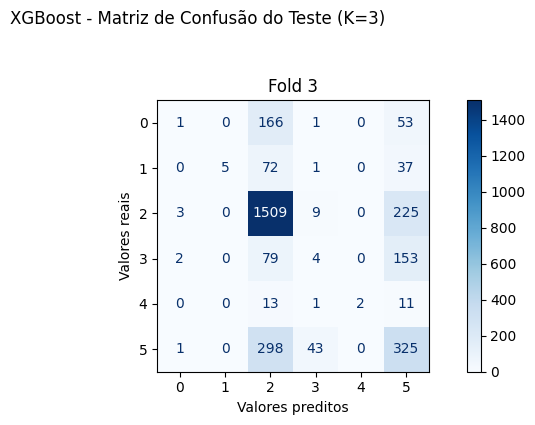

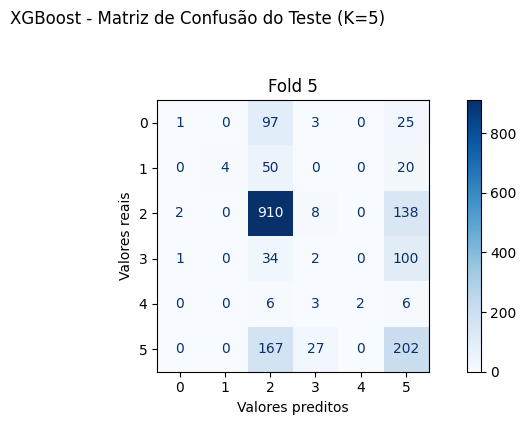

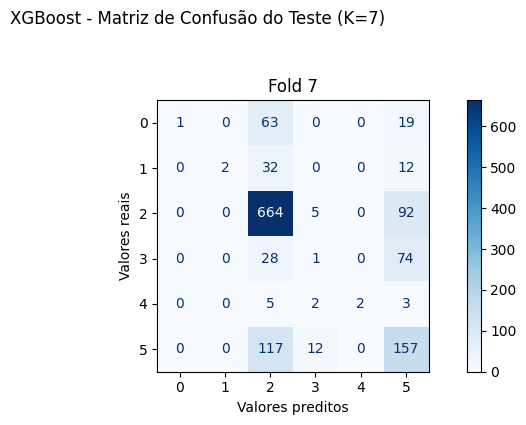

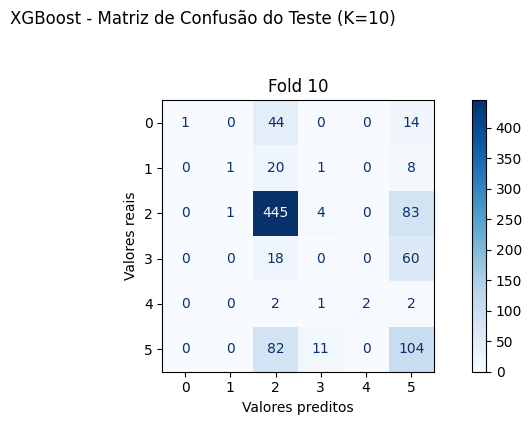


 Resumo Estatístico - XGBoost
K     F1-Score   Precision  Recall    
----------------------------------------
3     0.5707     0.5822     0.6264     
5     0.5728     0.5703     0.6301     
7     0.5734     0.5718     0.6313     
10    0.5707     0.5646     0.6283     




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


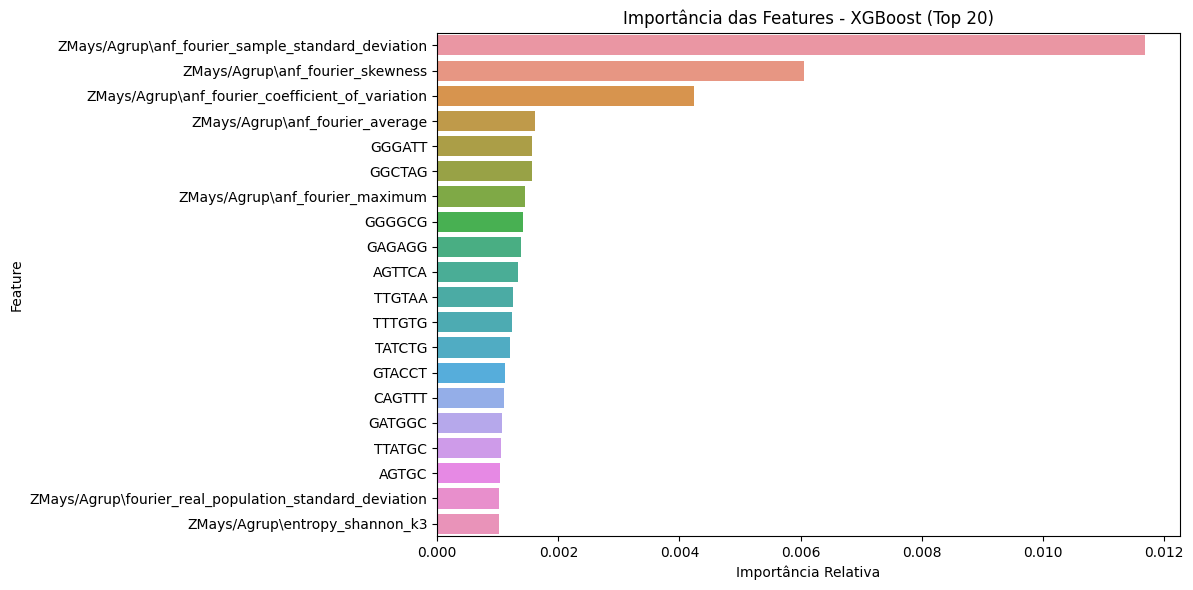

--- Avaliação de XGBoost Concluída ---


In [30]:
models_to_analyze = [
    {
        "display_name": "Random Forest",
        "internal_name": "RF",
        "model_object_path": "/kaggle/input/modelskfoldzeamays/modelo_rf_kfold.joblib"
    },
    {
        "display_name": "XGBoost",
        "internal_name": "XGBoost",
        "model_object_path": "/kaggle/input/modelskfoldzeamays/modelo_xgboost_kfold.joblib"
    }
    
]

results_file_path = "/kaggle/input/modelskfoldzeamays/modelo_evaluation_kfold.joblib"
k_values = [3, 5, 7, 10]

try:
    
    all_results = joblib.load(results_file_path)
    results_dict = {res['model_name']: res for res in all_results}
    print(f"Arquivo de resultados '{results_file_path}' carregado com sucesso.")
    
except FileNotFoundError:
    
    results_dict = None
    print(f"ERRO: Arquivo de resultados '{results_file_path}' não encontrado. Verifique o caminho.")
    
except Exception as e:
    
    results_dict = None
    print(f"Ocorreu um erro inesperado ao carregar os resultados: {e}")

if results_dict:
    
    print("\n--- INICIANDO GERAÇÃO DE GRÁFICOS ---")
    
    for model_info in models_to_analyze:
        display_name = model_info['display_name']
        internal_name = model_info['internal_name']
        model_path = model_info['model_object_path']

        print(f"\n{'='*20} ANÁLISE DO MODELO: {display_name.upper()} {'='*20}")

        if internal_name not in results_dict:
            print(f"AVISO: Resultados para '{internal_name}' não encontrados no arquivo de avaliação. Pulando este modelo.")
            continue
        
        try:
            
            model_object = joblib.load(model_path)
            print(f"Objeto do modelo carregado de: {model_path}")

            current_results = results_dict[internal_name]

            # Chama a função de plotagem
            # A variável 'feature_names' deve existir da célula de pré-processamento!
            plot_single_model_results(
                display_name=display_name,
                model_results=current_results,
                model_object=model_object,
                k_values=k_values,
                feature_names=feature_names
            )
            
        except FileNotFoundError:
            
            print(f"ERRO: Arquivo do modelo não encontrado em '{model_path}'. Verifique o caminho. Pulando este modelo.")
            
        except Exception as e:
            
            print(f"ERRO ao processar o modelo '{display_name}': {e}")